## Test of the new RandomPassive class

We now have a new class called `RandomPassive`, which gives three posible configurations of passive volumes:
 - Simple: a two-material block smaller than 1 m^3 
 - Intermediate: a bigger volume 
 - Complex: a cargo-like passive with dimensions around 6 x 2.5 x 2.5 m^3, with a wider variety of materials inside

In [1]:
from volume.passives_database import RandomPassive
from torch import Tensor

In [2]:
passive_layers, rl, should_open = RandomPassive(lwh=Tensor([1,1,2]),
                                                n_blocks=3,
                                                get_layers=True, 
                                                truck_frame=False,
                                                ).custom()
passive_layers, should_open

([PassiveLayer located at z=tensor([2.]),
  PassiveLayer located at z=tensor([1.8000]),
  PassiveLayer located at z=tensor([1.6000]),
  PassiveLayer located at z=tensor([1.4000]),
  PassiveLayer located at z=tensor([1.2000]),
  PassiveLayer located at z=tensor([1.0000]),
  PassiveLayer located at z=tensor([0.8000]),
  PassiveLayer located at z=tensor([0.6000]),
  PassiveLayer located at z=tensor([0.4000]),
  PassiveLayer located at z=tensor([0.2000])],
 True)

In [3]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from torch import Tensor, nn 
import torch
from tomopt.volume import Volume

In [4]:
init_xyz_span, xyz_gap = [1.5, 1.5, .3], [.1, .1, .1]
init_eff, init_res = 0.90, 1e3

In [5]:
hod_above = [Hodoscope(init_xyz= [0., 0., passive_layers[0].z+0.5], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res,
                      panel_type='SigmoidDetectorPanel',
                      smooth=0.5
                      ) ]


hod_below = [Hodoscope(init_xyz= [0.5, 0.5, -0.3], 
                    init_xyz_span = init_xyz_span, 
                    xyz_gap = xyz_gap, 
                    eff = init_eff,
                    res = init_res,
                    panel_type='SigmoidDetectorPanel',
                    smooth=0.5
                    ) ]

hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                            lw = Tensor([2,2]), 
                                            z = passive_layers[0].z+1, size = 1., 
                                            hodoscopes = hod_above)


hod_detector_below = HodoscopeDetectorLayer(pos = 'below', 
                                            lw = Tensor([2,2]), 
                                            z = .2, size = 1., 
                                            hodoscopes = hod_below)

In [6]:
def get_layers():
    layers = []
    layers.append(hod_detector_above)
    [layers.append(passive_layers[i]) for i in range(len(passive_layers))]
    layers.append(hod_detector_below)

    return nn.ModuleList(layers)


volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): HodoscopeDetectorLayer(
      (hodoscopes): ModuleList(
        (0): Hodoscope()
      )
    )
    (1): PassiveLayer located at z=tensor([2.])
    (2): PassiveLayer located at z=tensor([1.8000])
    (3): PassiveLayer located at z=tensor([1.6000])
    (4): PassiveLayer located at z=tensor([1.4000])
    (5): PassiveLayer located at z=tensor([1.2000])
    (6): PassiveLayer located at z=tensor([1.0000])
    (7): PassiveLayer located at z=tensor([0.8000])
    (8): PassiveLayer located at z=tensor([0.6000])
    (9): PassiveLayer located at z=tensor([0.4000])
    (10): PassiveLayer located at z=tensor([0.2000])
    (11): HodoscopeDetectorLayer(
      (hodoscopes): ModuleList(
        (0): Hodoscope()
      )
    )
  )
)

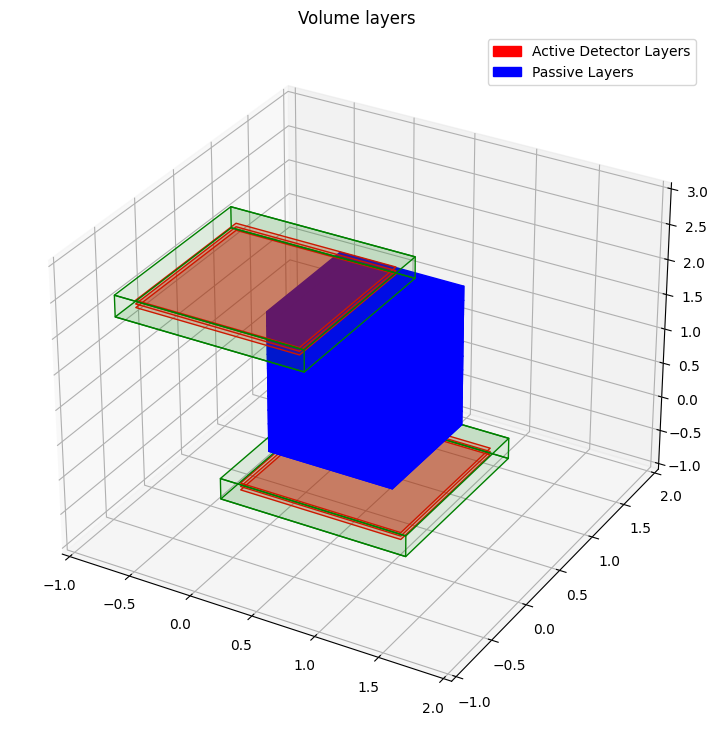

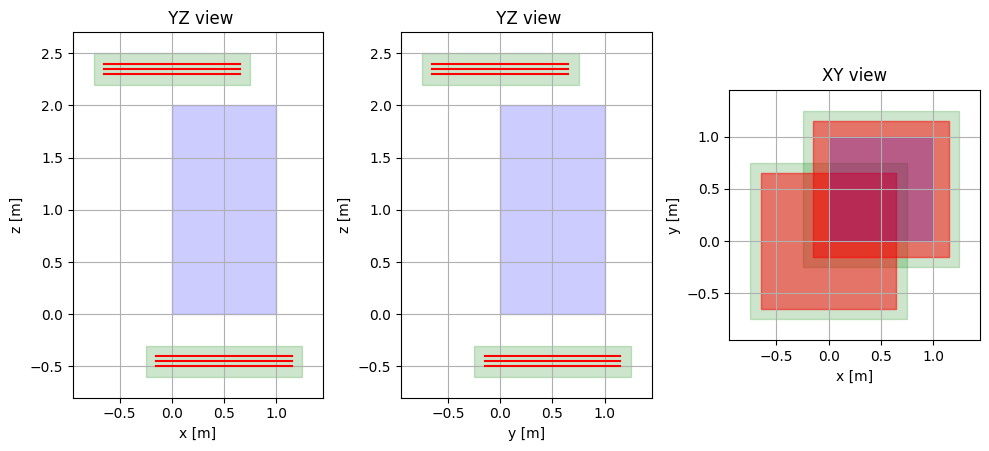

(None, None)

In [7]:
from plotting.plotting import draw, draw_volume_2D
draw(volume, [-1.,2.], [-1., 2.], [-1.,volume.h]), draw_volume_2D(volume)

In [8]:
from functools import partial
from tomopt.optimisation import VoxelX0Loss
from optimisation.hodoscope_volume_wrapper import HodoscopeVolumeWrapper

wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

In [9]:
from tomopt.optimisation import MuonResampler
from tomopt.optimisation import PassiveYielder

passives = PassiveYielder([rl])

preds = wrapper.predict(passives,
                        n_mu_per_volume=1000,
                        mu_bs=500,
                        cbs=[MuonResampler()])

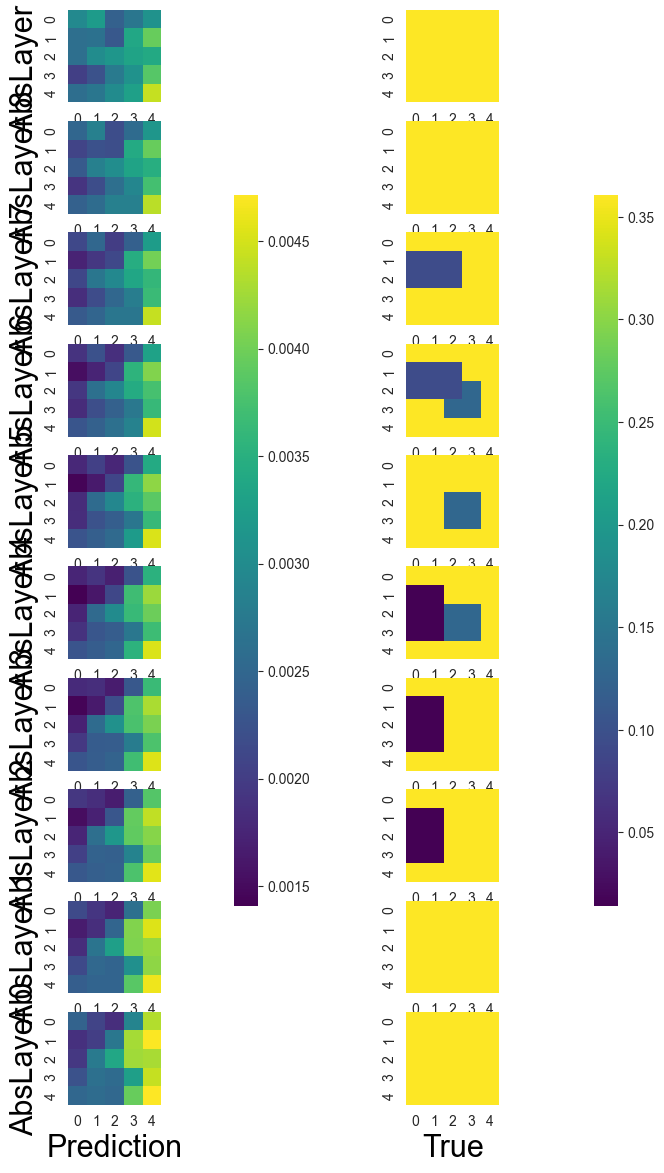

In [10]:
from tomopt.plotting import plot_pred_true_x0
plot_pred_true_x0(*preds[0])